In [1]:
import numpy as np
import matplotlib.pyplot as plt

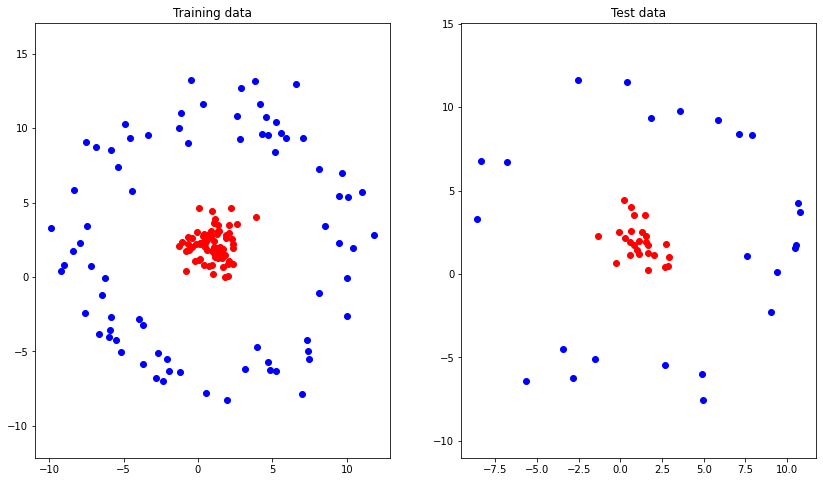

In [2]:
def generate_data():
    mu_1 = np.array([1.0, 2.0])
    sigma_1 = 1
    num_sample = 100
    cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
    X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)
    angle = np.random.uniform(0, 2*np.pi, num_sample)
    d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
    X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T
    X = np.concatenate([X1, X2],axis = 0)
    y = np.append(-np.ones(num_sample),np.ones(num_sample))[:,np.newaxis]
    idx = np.arange(0, num_sample*2)
    np.random.shuffle(idx)
    train_idx = idx[0:150]
    test_idx = idx[150:]
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx,:]
    y_test = y[test_idx,:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = generate_data()

def plot_data(X, y, title):
    X_0 = X[(y==-1).flat]
    X_1 = X[(y==1).flat]
    plt.plot(X_0[:,0], X_0[:,1], 'ro')
    plt.plot(X_1[:,0], X_1[:,1], 'bo')
    plt.title(title)
    plt.axis('equal')
    
plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')

Let's build a soft-margin linear SVM for this dataset. Recall the QP setting.
A QP problem aims to find $\textbf{x}$ satisfying
$$
\begin{array}{rl}
\text{min}_{\textbf{x}} & \frac{1}{2}\textbf{x}^\top \texttt{Q} \textbf{x} + \textbf{c}^\top\textbf{x} \\
\text{subject to}       & \texttt{A}\textbf{x} \le \textbf{b} \\
                        & \texttt{E}\textbf{x} = \textbf{d} .
\end{array}
$$

First, we need our wrapper for cvxopt:

In [3]:
import cvxopt

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

In [4]:
C = 1000.1

m = X_train.shape[0];
n = X_train.shape[1];

def linear_kernel(X):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = X[i,:] @ X[j,:].T
    return K;

def gauss_kernel(X):
    sigma = 0.2
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:] - X[j,:]).reshape(1,-1) @ (X[i,:] - X[j,:]).reshape(-1,1)
    K = np.exp(-K/(2*sigma*sigma))      
    return K;

K = gauss_kernel(X_train);

Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);
b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
E = y_train.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);

#print(alpha_star)

Q rank: 150
     pcost       dcost       gap    pres   dres
 0:  8.8235e+06 -3.1394e+07  4e+07  1e-12  2e-13
 1:  2.1125e+06 -3.1121e+06  5e+06  1e-12  1e-13
 2:  3.1285e+05 -3.7028e+05  7e+05  4e-13  6e-14
 3:  4.4214e+04 -5.2998e+04  1e+05  7e-13  2e-14
 4:  5.9687e+03 -7.8732e+03  1e+04  7e-14  1e-14
 5:  6.9440e+02 -1.2778e+03  2e+03  2e-14  3e-15
 6:  2.0316e+01 -2.5411e+02  3e+02  1e-14  1e-15
 7: -4.7929e+01 -8.0217e+01  3e+01  4e-15  4e-16
 8: -5.1195e+01 -5.3575e+01  2e+00  2e-15  2e-16
 9: -5.1336e+01 -5.1693e+01  4e-01  2e-16  2e-16
10: -5.1371e+01 -5.1418e+01  5e-02  1e-15  2e-16
11: -5.1374e+01 -5.1375e+01  1e-03  7e-16  2e-16
12: -5.1374e+01 -5.1374e+01  6e-05  1e-15  2e-16
13: -5.1374e+01 -5.1374e+01  6e-06  1e-15  2e-16
Optimal solution found.


Let's get $\mathbf{w}$ and $b$ and plot:

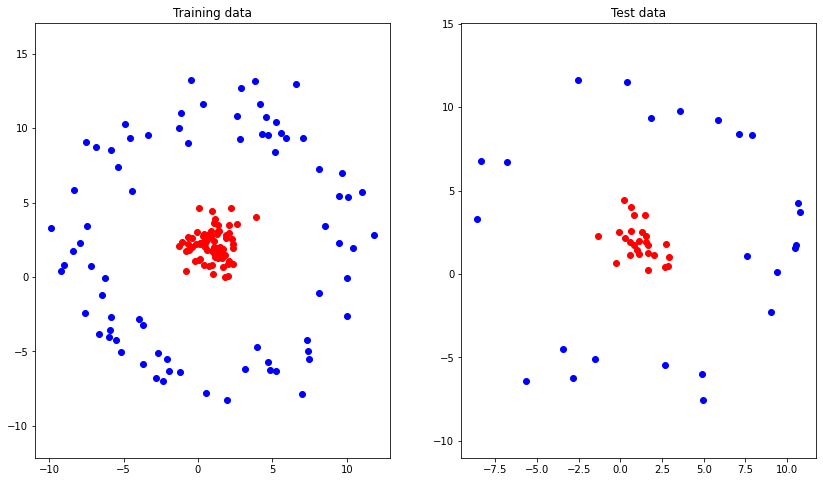

In [5]:
def get_wb(X, y, alpha):
    n = X.shape[1]
    # Find the support vectors
    S = alpha > 1e-6
    XS = X[S,:]
    yS = y[S]
    alphaS = alpha[S]
    alphaSyS = np.tile(np.multiply(yS.T, alphaS).T, n)
    w = sum(np.multiply(alphaSyS, XS)).T
    # Find b
    KS = K[S,:][:,S]
    NS = yS.shape[0]
    b = (np.sum(yS) - np.sum(np.multiply(alphaS,yS.T)*KS))/NS
    # Normalize w,b
    scalef = np.linalg.norm(w)
    w = w / scalef
    b = b / scalef
    return w,b

def boundary_points(X, w, b):
    v_orthogonal = np.array([[w[0]],[w[1]]])
    v_ortho_length = np.sqrt(v_orthogonal.T @ v_orthogonal)
    dist_ortho = b / v_ortho_length
    v_orthogonal = v_orthogonal / v_ortho_length
    v_parallel = np.array([[-v_orthogonal[1,0]],[v_orthogonal[0,0]]])
    projections = X @ v_parallel
    proj_1 = min(projections)
    proj_2 = max(projections)
    point_1 = proj_1 * v_parallel - dist_ortho * v_orthogonal
    point_2 = proj_2 * v_parallel - dist_ortho * v_orthogonal
    return point_1, point_2

def plot_w(X, w, b):
    p1, p2 = boundary_points(X, w, b)
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')
    
w,b = get_wb(X_train, y_train, alpha_star)

plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
#plot_w(X_train, w, b)
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')
#plot_w(X_test, w, b)


In [9]:
def predict(X_train, y_train,alpha,X):
    n = X_train.shape[1]
    S = alpha > 1e-6
    XS = X_train[S,:]
    yS = y_train[S]
    alphaS = alpha[S]
    
    KS = gauss_kernel(XS)
    NS = yS.shape[0]
    alphaSyS = np.multiply(alphaS,yS.T)
    b = (np.sum(yS) - np.sum(alphaSyS*KS))/NS
    
    KSX = gauss_kernel_2(X_train,X)
    return (alphaSyS@KSX + b).T

def accuracy(y_t,y_pred):
    return (np.sum(y_t.reshape(-1)==y_pred)/y_t.size)

y_pred = predict(X_train,y_train,alpha_star,X_test)
print(y_pred)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 150 is different from 144)

In [ ]:
resolution = 100
x_series = np.linspace(-10,10,resolution)
y_series = np.linspace(-10,10,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

In [ ]:
acc = []

K = linear_kernel(X_train);

Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);

C_range = np.logspace(-5,5,20)
for C in C_range:
    b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
    E = y_train.T;
    d = np.zeros(1);
    alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
    w,b = get_wb(X_train, y_train, alpha_star)
    print(w,b)
    y_pred = predict(w,b,X_test)
    acc.append(accuracy(y_test,y_pred))
    
acc = np.array(acc)
print(acc)

In [ ]:
print("Best value for C = ", C_range[np.argmax(acc)])

## To do in lab

Do the following:
1. Implement a function to evaluate the accuracy of your SVM on the test set
2. Implement a search procedure to find the best value of $C$.
Report your findings in the lab report.

## Take home exercise

Remember the 2D annulus problem with overlap? Get the code above working on that example. You'll need to use the
Gaussian kernel rather than the linear kernel. Report your findings in the lab report. Your hyperparameter search
should be over both $C$ and $\sigma$ ($\gamma$ in some descriptions of the Gaussian/RBF kernel).


## Exercise 2: SMO optimization

As we have learned, the QP solution to the SVM is not practical for large datasets.

Next, we'll get the general idea of the SMO algorithm used to optimize large SVMs in practice. The idea is similar to
coordinate ascent except that we cannot manipulate $\alpha_i$'s independently due to the KKT constraints required for
equivalence of the primal and dual form of the constrained optimization problem.

This example has been adapted from
[An Introduction to Support Vector Machine (SVM) and the Simplified SMO Algorithm](https://www.codeproject.com/Articles/1267445/An-Introduction-to-Support-Vector-Machine-SVM-and) by "Coding Notes."

We begin with all $\alpha_i=0$.
We repeatedly iterate over all $\alpha_i$, $i \in 1..m$. If $\alpha_i$ does not fulfill the KKT conditions, then we
must consider optimizing $\alpha_i$ in concert with some other $\alpha_j$. The KKT conditions imply that if $\alpha_i = 0$, then
it must be the case that $y^{(i)} h(\mathbf{x}^{(i)}) > 1$, and if $0 < \alpha_i < C$, it must be the case that $y^{(i)} h(\mathbf{x}^{(i)}) = 1$.

If either of these constraints are violated, we
select an $\alpha_j$ at random from the remaining $(m − 1)$ $\alpha$ variables and then jointly optimize $\alpha_i$ and $\alpha_j$,
holding all other $\alpha_k$ fixed.

If the vector $\mathbf{\alpha}$ does not change after some number of passes, then the algorithm terminates.

To optimize the pair $(\alpha_i,\alpha_j)$, we do the following:
 - $E_i \leftarrow h(\mathbf{x}^{(i)}) - y^{(i)}$
 - $E_j \leftarrow h(\mathbf{x}^{(j)}) - y^{(j)}$
 - $\alpha_j^{(old)} \leftarrow \alpha_j$
 - $\alpha_j' \leftarrow \alpha_j^{(old)} - \frac{y^{(j)}(E_i - E_j)}{\eta}$ 
 - $\eta = 2 \langle x^{(i)}, x^{(j)} \rangle - \langle x^{(i)} , x^{(i)} \rangle - \langle x^{(j)}, x^{(j)} \rangle$
 - $L = \begin{cases} \max(0, \alpha_i + \alpha_j − C)  & \text{if} \; y^{(i)} = y^{(j)} \\
                      \max(0, \alpha_j − \alpha_i)      & \text{otherwise} \end{cases}$
 - $H = \begin{cases} \min(C, \alpha_i + \alpha_j)      & \text{if} \; y^{(i)} = y^{(j)} \\
                      \min(C, C + \alpha_j − \alpha_i) & \text{otherwise}\end{cases}$
 - $\alpha_j \leftarrow \begin{cases} H & \text{if} \; \alpha_j' > H \\
                                      \alpha_j' & \text{if} \; L \le \alpha_j' \le H \\
                                      L & \text{otherwise} \end{cases}$
 - $\alpha_i \leftarrow \alpha_i + y^{(i)} y^{(j)} ( \alpha_j^{(old)} - \alpha_j )$

After optimizing $\alpha_i$ and $\alpha_j$, we select the threshold $b$ as
$$ b= \begin{cases} b_1 &  0  \lt \alpha_i \lt C \\ b_2 &  0  \lt \alpha_j \lt C  \\ otherwise \end{cases}$$

where $b_1 = b - E_i - y^{(i)}(\alpha_i - \alpha_i^{(old)})\langle x^{(i)},x^{(i)}\rangle - y^{(i)}(\alpha_j-\alpha_j^{(old)})\langle x^{(i)},x^{(j)} \rangle$

and $b_2 = b - E_i - y^{(i)}(\alpha_i - \alpha_i^{(old)})\langle x^{(i)},x^{(j)}\rangle - y^{(j)}(\alpha_j-\alpha_j^{(old)})\langle x^{(j)},x^{(j)} \rangle$

In [ ]:
import random
import matplotlib.patches as mpatches

# Convert lists into matrix
def mat(lists):
    return np.matrix(lists)

def selectJrandom(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlphaJ(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

def simplifiedSMO(dataX, classY, C, tol, max_passes):
    X = mat(dataX)
    Y = mat(classY).T
    m,n = np.shape(X)
    # Initialize b: threshold for solution
    b = 0;      
    # Initialize alphas: lagrange multipliers for solution
    alphas = mat(np.zeros((m,1)))
    passes = 0
    while (passes < max_passes):
        num_changed_alphas = 0
        for i in range(m):
            # Calculate Ei = f(xi) - yi
            fXi = float(np.multiply(alphas,Y).T*(X*X[i,:].T)) + b
            Ei = fXi - float(Y[i])
            if ((Y[i]*Ei < -tol) and (alphas[i] < C)) or ((Y[i]*Ei > tol) and (alphas[i] > 0)):
                # select j # i randomly
                j = selectJrandom(i,m)
                # Calculate Ej = f(xj) - yj
                fXj = float(np.multiply(alphas,Y).T*(X*X[j,:].T)) + b
                Ej = fXj - float(Y[j])
                # save old alphas's
                alphaIold = alphas[i].copy();
                alphaJold = alphas[j].copy();
                # compute L and H
                if (Y[i] != Y[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # if L = H the continue to next i
                if L==H:
                    continue
                # compute eta
                eta = 2.0 * X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                # if eta >= 0 then continue to next i
                if eta >= 0:
                    continue
                # compute new value for alphas j
                alphas[j] -= Y[j]*(Ei - Ej)/eta
                # clip new value for alphas j
                alphas[j] = clipAlphaJ(alphas[j],H,L)
                # if |alphasj - alphasold| < 0.00001 then continue to next i
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    continue
                # determine value for alphas i
                alphas[i] += Y[j]*Y[i]*(alphaJold - alphas[j])
                # compute b1 and b2
                b1 = b - Ei- Y[i]*(alphas[i]-alphaIold)*X[i,:]*X[i,:].T - Y[j]*(alphas[j]-alphaJold)*X[i,:]*X[j,:].T
                b2 = b - Ej- Y[i]*(alphas[i]-alphaIold)*X[i,:]*X[j,:].T - Y[j]*(alphas[j]-alphaJold)*X[j,:]*X[j,:].T
                # compute b
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0                      
                num_changed_alphas += 1
            if (num_changed_alphas == 0): passes += 1
            else: passes = 0
    return b,alphas

def computeW(alphas, dataX, classY):
    X = mat(dataX)
    Y = mat(classY).T
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*Y[i],X[i,:].T)
    return w

def plotLinearClassifier(point, w, alphas, b, dataX, labelY):      
    np.shape(alphas[alphas>0])
      
    Y = np.array(labelY)
    X = np.array(dataX)
    svmMat = []
    alphaMat = []
    for i in range(10):
        alphaMat.append(alphas[i])
        if alphas[i]>0.0:
            svmMat.append(X[i])
                                 
    svmPoints = np.array(svmMat)
    alphasArr = np.array(alphaMat)

    numofSVMs = np.shape(svmPoints)[0]
    print("Number of SVM points: %d" % numofSVMs)
 
    xSVM = []; ySVM = []
    for i in range(numofSVMs):
        xSVM.append(svmPoints[i,0])
        ySVM.append(svmPoints[i,1])    
     
    n = np.shape(X)[0]    
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
      
    for i in range(n):
        if int(labelY[i])== 1:
            xcord1.append(X[i,0])
            ycord1.append(X[i,1])                  
        else:
            xcord2.append(X[i,0])
            ycord2.append(X[i,1])                  

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    for j in range(0,len(xcord1)):
        for l in range(numofSVMs):
            if (xcord1[j]== xSVM[l]) and (ycord1[j]== ySVM[l]):
                ax.annotate("SVM", (xcord1[j],ycord1[j]), (xcord1[j]+1,ycord1[j]+2),
                                   arrowprops=dict(facecolor='black', shrink=0.005))
      
    ax.scatter(xcord2, ycord2, s=30, c='green')
    for k in range(0,len(xcord2)):
        for l in range(numofSVMs):
            if (xcord2[k]== xSVM[l]) and (ycord2[k]== ySVM[l]):
                ax.annotate("SVM", (xcord2[k],ycord2[k]),(xcord2[k]-1,ycord2[k]+1),
                            arrowprops=dict(facecolor='black', shrink=0.005))
      
    red_patch = mpatches.Patch(color='red', label='Class 1')
    green_patch = mpatches.Patch(color='green', label='Class -1')
    plt.legend(handles=[red_patch,green_patch])
      
    x = []
    y = []
    for xfit in np.linspace(-3.0, 3.0):
        x.append(xfit)
        y.append(float((-w[0]/w[1])*xfit - b[0,0])/w[1])
             
    ax.plot(x,y)
      
    predictedClass(point,w,b)
    p = mat(point)
    ax.scatter(p[0,0], p[0,1], s=30, c='black', marker='s')
    circle1=plt.Circle((p[0,0],p[0,1]),0.6, color='b', fill=False)
    plt.gcf().gca().add_artist(circle1)
      
    plt.show()

def predictedClass(point, w, b):
    p = mat(point)
    f = p*w + b
    if f > 0:
        print(point," belongs to Class 1")
    else:
        print(point," belongs to Class -1")   


In [ ]:
# We create 10 examples five for class -1 and five for class 1
X = list([[-3,-2],[-2,3],[-1,-4],[2,4],[3,4],[-1,9],[2,14],[1,17],[3,12],[0,8]])
Y  = list([-1,-1,-1,-1,-1,1,1,1,1,1])
b,alphas = simplifiedSMO(X, Y, 0.6, 0.001, 40)
w = computeW(alphas,X,Y)
# test with the data point (3, 4)
plotLinearClassifier([3,4], w, alphas, b, X, Y)

In [ ]:
b,alphas = simplifiedSMO(X_train, y_train.reshape(-1), 0.004, 0.00001, 40)
w = computeW(alphas,X_train,y_train.reshape(-1))
# test with the data point (3, 4)
#plotLinearClassifier([3,4], w, alphas, b, X, Y)
b = b[0,0]
w = w.reshape(-1)
print(b)
print(w)

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plot_w(X_train, w, b)
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')
plot_w(X_test, w, b)


## In lab exercise

Apply the SMO code above to the dataset from Exercise 1. Report your results in your lab report.

## Take home exercise

Modify the SMO code above to use a kernel other than the linear kernel, and apply it to the annulus dataset from Exercise 1.
Report your results in your lab report.
